<a href="https://colab.research.google.com/github/hsimonfroy/diffusion-field-level/blob/main/tests/TSM_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling using the TSM objective


In [1]:
!pip install --quiet diffrax

In [2]:
%pylab inline
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

Populating the interactive namespace from numpy and matplotlib


## Step I: Create a target distribution to sample

Here we will define a target distribution of flexible difficulty as a gaussian mixture model.

Here we can use a VP SDE that converges with a normal distribution.

In that case:

$$ f(x,t) = -\frac{1}{2} \beta(t) x   \ \mbox{and} \  g(t) = \sqrt{\beta(t)}$$


And we are going to adopt the same solution for alpha and beta of the VP-SDE as described in Song and friends (Appending B):

$$\beta(t) = \beta_{min} + t(\beta_{max} - \beta_{min})$$

$$\alpha(t) = e^{-\frac{1}{2} t^2 (\beta_{max} - \beta_{min}) - t \beta_{min}} $$

And they recommend using $\beta_{min}=0.1$ and $\beta_{max}=20$.

In that simple case, our ODE becomes #NO:

$$\mathrm{d}x = \left[-\frac{1}{2} \beta(t) x - \frac{1}{2} \sqrt{\beta(t)} \nabla_x \log p_{\alpha_t}(x) \right] \mathrm{d}t$$


And, and also, the distribution $p_{\alpha_t}$ is given by:

$$ \mathcal{N}(x; \sqrt{\alpha(t)}x, (1 - \alpha(t)) I ) $$

Let's see what this would look like on our toy distribution

In [3]:
# Defining auxiliary functions
def beta(t, bmin=0.1, bmax=20):
  return bmin + t*(bmax - bmin)

def alpha(t,bmin=0.1, bmax=20):
  return jnp.exp(-0.5*t**2*(bmax -bmin) - t*bmin)

In [4]:
def make_dist(alpha=0.):
  """
  Returns a mixture of Gaussians, convolved with a Gaussian of specified sigma
  """
  gm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.5, 0.5]),
    components_distribution=tfd.Normal(
      loc=jnp.sqrt(alpha)*jnp.array([-1., 1.]),
      scale=[jnp.sqrt(alpha*0.4**2+ (1 - alpha)),
             jnp.sqrt(alpha*0.2**2+ (1 - alpha))]))
  return gm

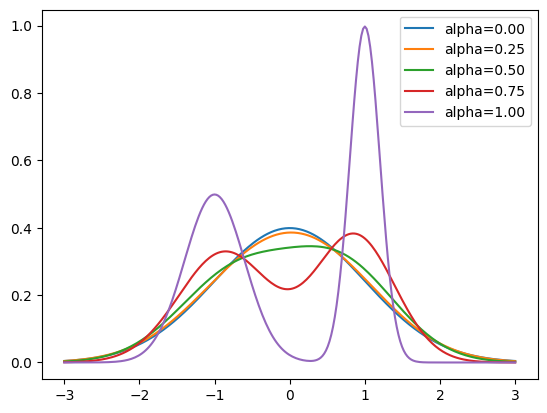

In [5]:
x = jnp.linspace(-3,3,256)
for i in [0.0, 0.25, 0.5, 0.75, 1.]:
  plot(x, make_dist(alpha=i).prob(x),label='alpha=%0.2f'%i);
legend();

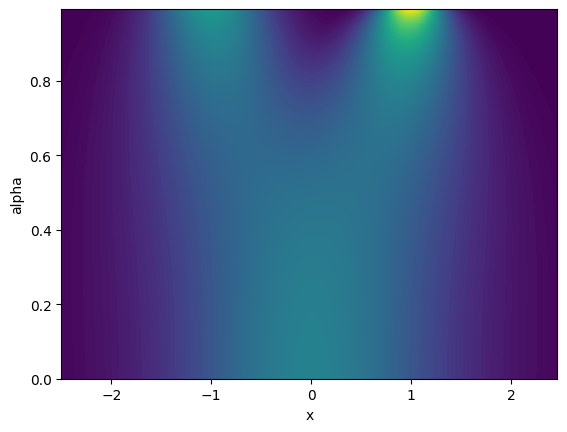

In [6]:
# We can also visualize this in 2D
xt = (np.stack(mgrid[0:128,0:128],axis=-1)/128 - np.array([0, 0.5]))*np.array([1., 5.])
t = xt[:,0,0]
x = xt[0,:,1]

contourf(x,t,
         jax.vmap(lambda u: make_dist(u[0]).prob(u[1]))(xt.reshape([-1,2])).reshape([128,128]),
         128)
xlabel('x');
ylabel('alpha');

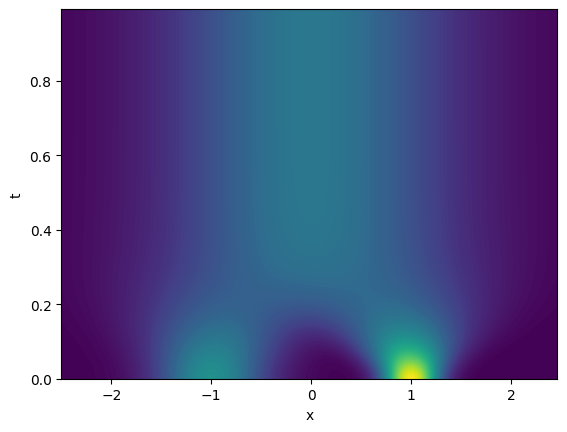

In [7]:
# Or as a function of time:
contourf(x,t,
         jax.vmap(lambda u: make_dist(alpha(u[0])).prob(u[1]))(xt.reshape([-1,2])).reshape([128,128]),
         128)
xlabel('x');
ylabel('t');

In [8]:
# We need to define the base distribution and our target distribution
T = 1
base = tfd.Normal(loc=0., scale=1.) # Base distribution derived from our choice of SDE
target = make_dist(alpha=1.)

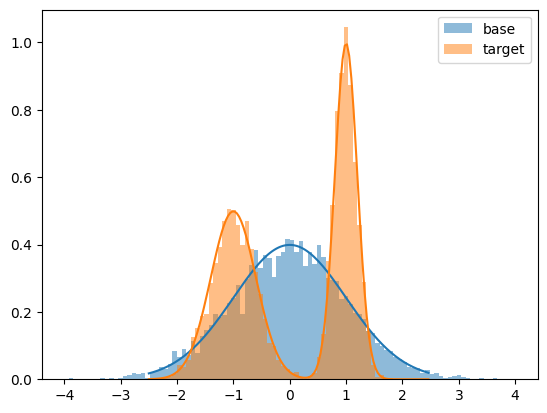

In [9]:
# Sample from the base and target distributions
num_samples = 5000
base_samples = base.sample(num_samples, seed=jax.random.PRNGKey(0))
target_samples = target.sample(num_samples, seed=jax.random.PRNGKey(1))

hist(base_samples, 100, range=[-4,4], label='base', color='C0', density=True,alpha=0.5);
plot(x, base.prob(x), color='C0');
hist(target_samples, 100, range=[-4,4], label='target', color='C1', density=True, alpha=0.5);
plot(x, target.prob(x), color='C1');
legend();

Let's try to verify that our integration time is going to be rougly good enough, by running an SDE forward for time T with samples from the target distribution and verifying that we get a distribution similar to base.

In [12]:
@jax.jit
@partial(jax.vmap, in_axes=(0, 0))
def forward_sde(key, x):
  t0, t1 = 0, T
  drift = lambda t, y, args: - 0.5 *beta(t) * y
  diffusion = lambda t, y, args: jnp.sqrt(beta(t))
  brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=key)
  terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
  solver = Euler()
  key, k = jax.random.split(key)
  saveat = SaveAt(ts=jnp.linspace(t0, t1, 100))
  sol = diffeqsolve(terms, solver, t0, t1, dt0=0.01, y0=x, saveat=saveat)
  return sol.ts, sol.ys

In [13]:
ts, xs = forward_sde(jax.random.split(jax.random.PRNGKey(0),num_samples), target_samples)

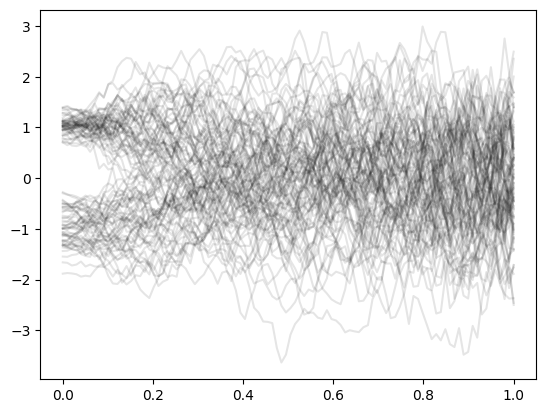

In [14]:
# Let's take a look at the trajectories
for i in range(100):
  plot(ts[i,:], xs[i,:], alpha=0.1, color='k');

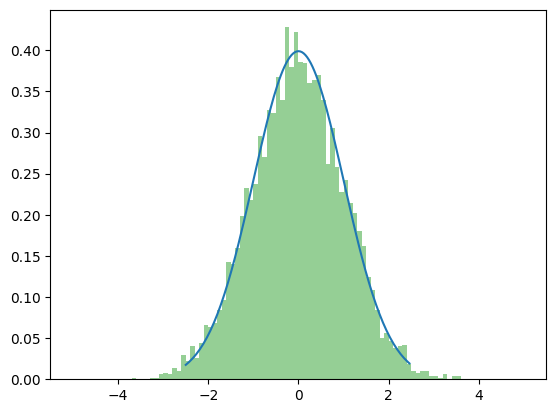

In [15]:
hist(xs[:,-1],100, range=[-5,5], label='sde', color='C2', density=True, alpha=0.5);
plot(x, base.prob(x), color='C0');

## Step II: Defining the score network and SDE

In [16]:
import flax.linen as nn

class ScoreNN(nn.Module):
    @nn.compact
    def __call__(self, x, t):
        # Encoding time
        freqs = (jnp.arange(10)+1)*np.pi
        t = freqs * jnp.atleast_1d(t)
        t = jnp.concatenate([jnp.sin(t), jnp.cos(t)],axis=-1)
        # Building network
        x = jnp.concatenate([jnp.atleast_1d(x), t])
        x = nn.Dense(features=256)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=256)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=256)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=1)(x)
        return x.squeeze()

score = ScoreNN()
params = score.init(jax.random.PRNGKey(0), jnp.zeros([1]), jnp.zeros([1]))

In [17]:
@jax.jit
@partial(jax.vmap, in_axes=(0, None))
def reverse_process(key, params):
  t0, t1 = 0, T
  drift = lambda t, y, args: - 0.5 *beta(t) * y - 0.5 *jnp.sqrt(beta(t)) * score.apply(args[0], y, t) #NO
  diffusion = lambda t, y, args: jnp.sqrt(beta(t)) #NO

#   score_marg = jax.grad(lambda t, y: make_dist(alpha(1-t)).log_prob(y), argnums=1) #YES
#   drift = lambda t, y, args: 0.5 *beta(1-t) * y + beta(1-t) * score_marg(t, y) #YES
#   diffusion = lambda t, y, args: jnp.sqrt(beta(1-t)) #YES

#   drift = lambda t, y, args: 0.5 *beta(1-t) * y + beta(1-t) * score.apply(args[0], y, t) #YES
#   diffusion = lambda t, y, args: jnp.sqrt(beta(1-t)) #YES

  brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=key)
  terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
  solver = Euler()
  key, k = jax.random.split(key)
  z = base.sample(seed=k)
  saveat = SaveAt(ts=jnp.linspace(t0, t1, 100))
  sol = diffeqsolve(terms, solver, t0, t1, dt0=0.05, y0=z.squeeze(), args=(params,), saveat=saveat) #NO
#   sol = diffeqsolve(terms, solver, t0, t1, dt0=1e-3, y0=z.squeeze(), args=(params,), saveat=saveat) #YES
  return sol.ts, sol.ys

In [18]:
# Let's sample from the untrained process
times, samples = reverse_process(jax.random.split(jax.random.PRNGKey(0),1000), params)

In [19]:
times.shape, samples.shape

((1000, 100), (1000, 100))

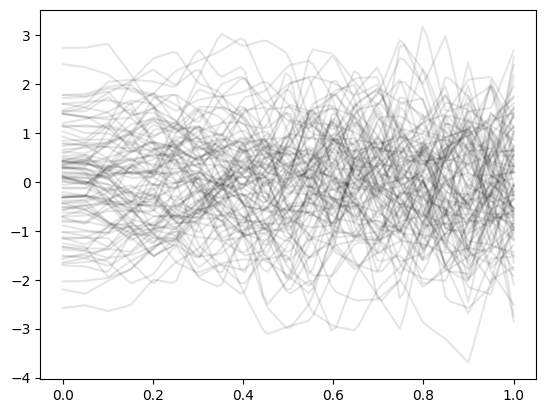

In [20]:
for i in range(100):
  plot(times[i,:], samples[i,:], alpha=0.1, color='k');

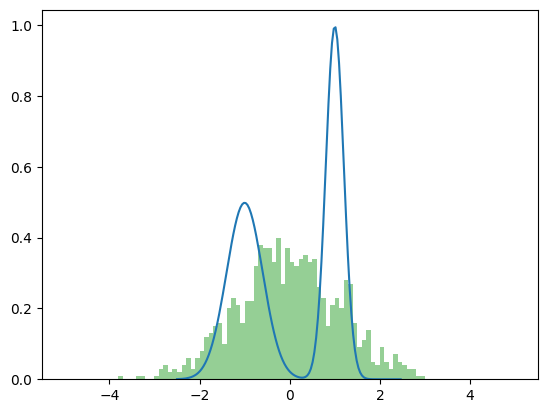

In [21]:
hist(samples[:,-1],100, range=[-5,5], label='sde', color='C2', density=True, alpha=0.5);
plot(x, target.prob(x), color='C0');

In [ ]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree

@jax.jit
@partial(jax.vmap, in_axes=(None, 0))
def compute_probability(params, x):
  # Let's use the formula log p_t(x) = log p_0(x_0) + \int_0^t div(score(X_s, s)) ds #NO
  # where X_s is the solution of dX_s = score(X_s, s) ds starting from x at time t and going backward to 0.
  t_start, t_end = 0, T

  def probability_flow_drift(t, y, args):
      x_val, log_p_val = y
      current_score = score.apply(args[0], jnp.atleast_1d(x_val), t).squeeze()
      drift_x = current_score #NO
      drift_log_p = jax.grad(lambda params, x, t: score.apply(params, jnp.atleast_1d(x), t).squeeze(), argnums=1)(args[0], x_val, t)
      return drift_x, drift_log_p

  terms = ODETerm(probability_flow_drift)
  solver = Euler()
  saveat = SaveAt(ts=[0])
  y0 = (x, 0.0) # Initial log_p is 0, we add log p_0(x_0) later.

  sol = diffeqsolve(terms, solver, t_start, t_end, dt0=0.05, y0=y0, args=(params,), saveat=saveat)
  # The output sol.ys will be a tuple of arrays when y0 is a tuple.
  # Each array in the tuple corresponds to a component of y0, and contains the values at the saved time points.
  # Since we are saving at a single time point (time 0), each array will have shape (1,).
  x_0_array, integral_div_score_array = sol.ys
  x_0 = x_0_array[0]
  integral_div_score = integral_div_score_array[0]

  log_p_0_x_0 = base.log_prob(x_0)

  return log_p_0_x_0 + integral_div_score

In [ ]:
@jax.jit
def fn(x):
  return jax.vmap(jax.grad(target.log_prob))(x)

def loss_fn(params, t, y, s, w):
  return jnp.mean(  w/jnp.mean(w) * (jax.vmap(score.apply, in_axes=(None, 0, 0))(params, y, t) - s)**2)

In [ ]:
import optax

# Define the optimizer
optimizer = optax.adam(learning_rate=1e-3)

# Initialize the optimizer state
optimizer_state = optimizer.init(params)

# Define the training step
@jax.jit
def train_step(params, optimizer_state, t, y, s, w):
    loss, grads = jax.value_and_grad(loss_fn)(params, t, y, s, w)
    updates, optimizer_state = optimizer.update(grads, optimizer_state, params)
    params = optax.apply_updates(params, updates)
    return params, optimizer_state, loss

# Training loop
batch_size = 1024
key = jax.random.PRNGKey(0)

losses = []

Epoch 0, Loss: 80.1658935546875
Epoch 10, Loss: 65.36994934082031
Epoch 20, Loss: 66.72303009033203
Epoch 30, Loss: 54.50110626220703
Epoch 40, Loss: 56.48236846923828
Epoch 50, Loss: 52.4732780456543
Epoch 60, Loss: 49.94120407104492
Epoch 70, Loss: 47.34421920776367
Epoch 80, Loss: 47.840328216552734
Epoch 90, Loss: 46.05952072143555
Epoch 100, Loss: 51.572086334228516
Epoch 110, Loss: 50.27569580078125
Epoch 120, Loss: 51.95936584472656
Epoch 130, Loss: 51.657325744628906
Epoch 140, Loss: 47.620826721191406
Epoch 150, Loss: 49.4185791015625
Epoch 160, Loss: 48.1578483581543
Epoch 170, Loss: 48.17338562011719
Epoch 180, Loss: 49.854766845703125
Epoch 190, Loss: 48.1634521484375


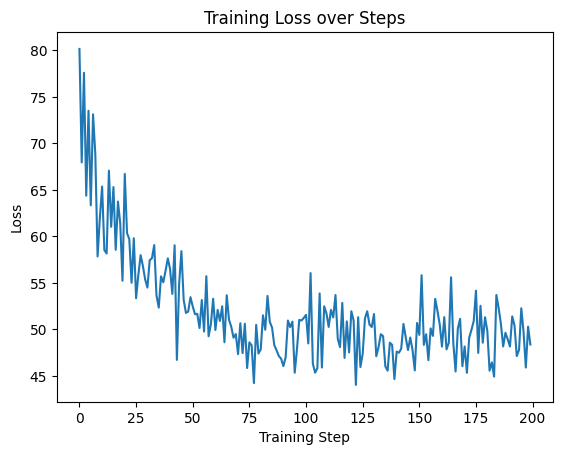

In [ ]:
for epoch in range(200):
  key, key_samples, key_t, key_x_t = jax.random.split(key, 4)

  # Sample a batch of trajectories from the forward process
  ts, Xs = reverse_process(jax.random.split(key_samples,batch_size), params)

  X_1 = Xs[:,0]
  ts = ts[:,:-1]
  # Reshape X_1 to match the shape of X_t before adding
  X_1 = jnp.repeat(X_1[:, None], ts.shape[1], axis=1)
  X_t = X_1 + jnp.sqrt(T-ts) * jax.random.normal(key_x_t, shape=ts.shape)

  # Flatten X_1, X_t, and ts
  X_1 = X_1.flatten()
  X_t = X_t.flatten()
  ts = ts.flatten()

  w = target.log_prob(X_1) - compute_probability(params, X_1)
  w = jnp.exp(w - jnp.max(w))
  w = w / jnp.sum(w)

  # Compute the score of the energy function
  scores = fn(X_1)

  params, optimizer_state, loss = train_step(params, optimizer_state, ts, X_t, scores, w)
  losses.append(loss)

  if epoch % 10 == 0:
    print(f'Epoch {epoch}, Loss: {loss}')

# Plot the training loss
plt.figure()
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.show()

In [ ]:
# Let's try to draw from the process now
ts, samples = reverse_process(jax.random.split(jax.random.PRNGKey(0),10000), params)

(-5.0, 5.0)

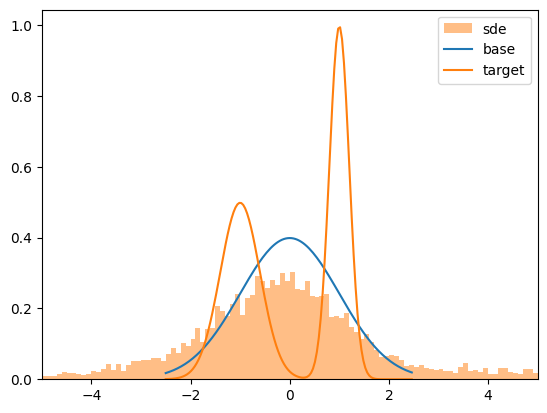

In [ ]:
plt.hist(samples[:,-1], 100, density=True, range=[-5,5], label='sde', alpha=0.5, color='C1');
plt.plot(x, base.prob(x), color='C0', label='base');
plt.plot(x, target.prob(x), color='C1', label='target');
plt.legend();
xlim(-5,5)

Let's take a look at the trajectories

(-4.0, 4.0)

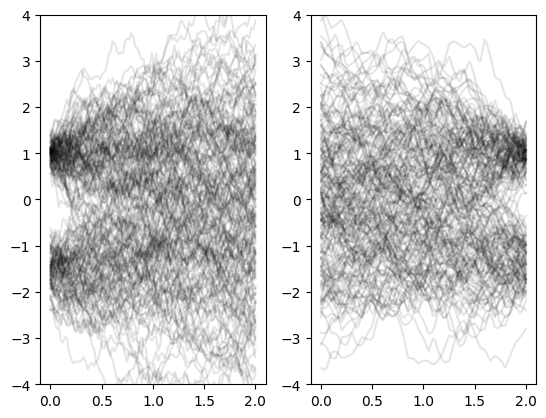

In [ ]:
# Let's take a look at the trajectories

subplot(121)
tts, xs = forward_sde(jax.random.split(jax.random.PRNGKey(0),num_samples), target_samples)
for i in range(200):
  plot(ts[i,:], xs[i,:], alpha=0.1, color='k');
ylim(-4,4)

subplot(122)
for i in range(200):
  plot(ts[i,::-1], samples[i,::-1], alpha=0.1, color='k');
ylim(-4,4)